# Imports

In [1]:
import tkinter
from PIL import Image, ImageTk, ImageDraw
import numpy as np
import random
import matplotlib.pyplot as plt
import networkx as nx
from scipy.sparse.csgraph import shortest_path
import scipy.stats as sts
import os
from joblib import Parallel, delayed, dump, load
import tempfile
import shutil
import tensorflow as tf
from tensorflow.keras.preprocessing.image import load_img, img_to_array
os.environ['TF_FORCE_GPU_ALLOW_GROWTH'] = 'true'
NET_THREE = 'Model_003' # the net-3 model to use
NET_SIX = 'Net6_003'    # the net-6 model to use

# Define all the functions to be used by the main GUI

In [2]:
def make_image_edges(img_orig, neighbors=4):
    """
    Create the bi-directional edges
    for the planar image. All pixels are
    used in this first step after which
    masked pixels will be removed.
    
    Inputs:
    img_orig : the original image file
    neighbors : either a 4- or 8-neighbor
                scheme, the latter includes
                diagonal neighbors
    
    Outputs:
    G : the initial Graph of the image
        plane edges - all bi-directional -
        and including the masked pixels
    """
    m, n = img_orig.size    # NOTE: n = height; m = width
    
    # create an array identical in shape to the image
    # This will serve as a guide for working the nodes
    # of the graph
    img = np.linspace(0, n*m-1, n*m).reshape(n,m).astype(int)
    
    G = nx.DiGraph() # instantiate the graph
    
    # ======================
    # build horizontal edges
    # ======================
    # add horizontal edges along first row
    #                            =========
    row = [(j,j+1) for j in range(0,m-1)]
    G.add_edges_from(row)
    # add reverse direction
    rev = [(y, x) for x, y in row]
    G.add_edges_from(rev)
    
    # use first row to define all other horizontal connections
    #                         ================================
    other_rows = [(x+j*m, y+j*m) for x, y in row for j in range(1,n)]
    G.add_edges_from(other_rows)
    # add reverse direction
    rev = [(y, x) for x, y in other_rows]
    G.add_edges_from(rev)

    # ====================
    # build vertical edges
    # ====================
    # add vertical edges along first row
    #                          =========
    col = [(j,j+m) for j in range(0,m)]
    G.add_edges_from(col)
    # add reverse direction
    rev = [(y, x) for x, y in col]
    G.add_edges_from(rev)

    # use first col to define all other vertical connections
    #                         ==============================
    other_cols = [(x+j*m, y+j*m) for x, y in col for j in range(1,n-1)]
    G.add_edges_from(other_cols)
    # add reverse direction
    rev = [(y, x) for x, y in other_cols]
    G.add_edges_from(rev)

    if neighbors == 8:
        # ========================
        # build dropping diagonals
        # ========================
        # add diagonals sloping downward for first row
        #                                    =========
        ddiag = [(j,j+m+1) for j in range(0,m-1)]
        G.add_edges_from(ddiag)
        # add reverse direction
        rev = [(y, x) for x, y in ddiag]
        G.add_edges_from(rev)

        # use first sloping diagonals to create all others
        #                                       ==========
        other_ddiag = [(x+j*m, y+j*m) for x, y in ddiag for j in range(1,n-1)]
        G.add_edges_from(other_ddiag)
        # add reverse direction
        rev = [(y, x) for x, y in other_ddiag]
        G.add_edges_from(rev)

        # ======================
        # build rising diagonals
        # ======================
        # add diagonals sloping upward on first row
        udiag = [(j,j+m-1) for j in range(1,m)]
        G.add_edges_from(udiag)
        # add reverse direction
        rev = [(y, x) for x, y in udiag]
        G.add_edges_from(rev)

        # use first sloping diagonals to create all others
        other_udiag = [(x+j*m, y+j*m) for x, y in udiag for j in range(1,n-1)]
        G.add_edges_from(other_udiag)
        # add reverse direction
        rev = [(y, x) for x, y in other_udiag]
        G.add_edges_from(rev)
    
    return G

def get_scrib_colors(img, clr, image_orig, sgmnt, counter):
    global G_rgb, pxl
    """
    Make an image with only the 
    colors of the pixels on the 
    scribble.
    Use the occasion to populate
    the graph with identity of foreground
    or background nodes
    
    Inputs:
    img : the image file of the scribble
    clr : the color to match
    image_orig : the original image file
    sgmnt : either foreground or background
    counter : keep track of foreground /
              background iteration
    
    Outputs:
    img_0 : the image with only 
            scribble pixels
    """
    # create a blank, black image
    img_0 = Image.new("RGB", img.size, (0,0,0))
    # populate the pixels as per the scribbled
    # image drawn by the user
    for node in G_rgb.nodes:
        # does the pixel match the scribble color?
        if img.getpixel(pxl[node]) == clr:
            # ... assign the original color
            img_0.putpixel(pxl[node], image_orig.getpixel(pxl[node]))
            # ... tag the node as belonging to 
            # either forground or background
            if counter == 1: # first pass: initialize attribute
                G_rgb.nodes[node][sgmnt] = counter
            elif G_rgb.nodes[node][sgmnt] == 0:
                # set to latest counter value only
                # if not previously assigned
                G_rgb.nodes[node][sgmnt] = counter
        else:
            G_rgb.nodes[node][sgmnt] = 0
    return img_0

def plot_hist(img, ax, bandwidth, subject):
    """
    Plot the histogram images.
    Stored in a file and then
    loaded anew.
    
    Input:
    img : the image file
    ax : the plotting axes
    bandwidth : bandwidth for the histogram
    subject : either fg or bk (fore/back ground)
    
    Output:
    None
    """
    # get the histogram data for object
    print(f"Getting histograms for {subject} ...")
    r, g, b, _, _, _ = get_hist_sums(img)
    ax.plot(r, color='red');
    ax.plot(g, color='green');
    ax.plot(b, color='blue');
    title_dic = {"fg": "Foreground ", "bk": "Background "}
    ax.set_title(title_dic[subject]+"Image Histogram",loc="left")
    # get the corresponding kde of the above data
    print(f"Getting KDE's ...")
    kde_r, kde_g, kde_b = get_kde(r, g, b, bandwidth)
    ax2 = ax.twinx()
    x = np.linspace(0,255,256)
    ax2.plot(x,kde_r.pdf(x),color='red',ls='--')
    ax2.plot(x,kde_g.pdf(x),color='green',ls='--')
    ax2.plot(x,kde_b.pdf(x),color='blue',ls='--')
    plt.show()
    return

def add_terminal(T, K, L, O, B, G_in, img, pxl, bw_O, bw_B):
    """
    Add a Terminal attached to each node 
    in G_in with corresponding capacity defined.
    Code and comments are written to reflect
        T = Terminal 'T'
        O = object or foreground
        B = background
    Can use this function to define S connections
    but one must reverse O and B in the reference 
    function call.
    
    Inputs:
        T : Either 'S' Source or 'T' Sink
            'S' is connected to foreground object
            'T' is connected to background
        K : variance of image calculated from greyscale
        L : lambda which multiplies the 
            probabilities
        O : Background image if T = 'S'
            (see Interactive Graph Cuts paper)
            Object image if T = 'T'
        B : opposite of O
        G_in : input graph
        img : baseline image
        pxl : dictionary of pixel x,y coords
        bw_O : bandwidth for foreground object
        bw_F : bandwidth for background
        
    Output:
        Graph with new terminal and capacities.
    """
    
    print(f"Adding Terminal {T} with K={K:.2f} and L={L:.2f} ...")
    
    tol = 1E-60 # define zero tolerance to catch issues
    # define ratio function and harmonic mean function
    f = lambda x, y: 0.5 if (x+y) == 0 else x / (x+y)
    hmn = lambda x, y, z: 0.5 if (x*y*z) <= tol else 3. / (1./x + 1./y + 1./z)
    
    G = G_in.copy()
    # get the histogram data for object and background
    r_O, g_O, b_O, _, _, _ = get_hist_sums(O)
    r_B, g_B, b_B, _, _, _ = get_hist_sums(B)

    n, m = O.size # get image size assuming all
                  # images provided to same size
    print(f"n:{n}, m:{m}")
    
    # get the corresponding kde of the above data
    kde_r_O, kde_g_O, kde_b_O = get_kde(r_O, g_O, b_O, bw_O)
    kde_r_B, kde_g_B, kde_b_B = get_kde(r_B, g_B, b_B, bw_B)
    
    # make a list of all nodes but
    # remove the terminal nodes from 
    # the list if they exist.
    nodes = list(G.nodes())
    try:
        nodes.remove('S')
    except:
        print('\tNo S-terminal found')
    try:
        nodes.remove('T')
    except:
        print('\tNo T-terminal found')
        
    G.add_node(T) # add the terminal node
    
    ttl = 0 # sum of three channels of zero color

    # loop through each node and assign
    # weights as per table from reference paper.
    # Note that these are the weights from a
    # terminal node to a pixel node. The weights
    # between pixels are defined in get_edge_weights
    for p in nodes:

        # check if part of object
        x, y = pxl[p]
        
        # in order to use this function for 
        # both Source and Sink we need to add
        # the following for proper directionality
        if T == "T":
            # here, from image to Sink
            from_node = p
            to_node = T
        else: # implies "S"
            # here, from Source to image
            from_node = T
            to_node = p
        
        # get corresponding pixel p in Object and Background
        r, g, b = O.getpixel((x, y)) # Object rgb
        r_b, g_b, b_b = B.getpixel((x,y)) # Background rgb
        
        # check if NOT black (hence, in Object)
        if sum([r, g, b]) != ttl:
            G.add_edge(from_node, to_node, capacity=0) # weight zero
            
        # check if NOT black (hence, in Background)
        elif sum([r_b, g_b, b_b]) != ttl:
            G.add_edge(from_node, to_node, capacity=K) # weight K
            
        # otherwise, assign regional weight
        else:
            r_i, g_i, b_i = img.getpixel((x, y)) # Image rgb
            
            Pr_r_O = kde_r_O.evaluate(r_i)[0] # foreground red probability
            Pr_g_O = kde_g_O.evaluate(g_i)[0] # foreground green probability
            Pr_b_O = kde_b_O.evaluate(b_i)[0] # foreground blue probability
            
            Pr_r_B = kde_r_B.evaluate(r_i)[0] # background red probability
            Pr_g_B = kde_g_B.evaluate(g_i)[0] # background green probability
            Pr_b_B = kde_b_B.evaluate(b_i)[0] # background blue probability
            
            
            # check if node has been created already
            if G.has_edge(from_node, to_node):
                # if so, then update as per top right column
                # of page 109 of Interactive Graph Cuts
                P_r_B = f(Pr_r_B, Pr_r_O) # prob red background
                P_g_B = f(Pr_g_B, Pr_g_O) # prob green background
                P_b_B = f(Pr_b_B, Pr_b_O) # prob blue background
                # calculate the overall probability as the harmonic
                # mean of the components
                prob_B = hmn(P_r_B, P_g_B, P_b_B)
                # avoid taking log of zero
                Rp = np.max([1./(m*n), prob_B])
#                 Rp = -np.log(np.sqrt(Rp)) # negative log liklihood
                Rp = -np.log(Rp) # negative log liklihood
                new_cpcty = (G[from_node][to_node]["capacity"]
                             + L*Rp
                             + (T=="S")*K)
                G[from_node][to_node]["capacity"] = new_capcty
            else:
                P_r_O = f(Pr_r_O, Pr_r_B) # prob red foreground
                P_g_O = f(Pr_g_O, Pr_g_B) # prob green foreground
                P_b_O = f(Pr_b_O, Pr_b_B) # prob blue foreground
                # calculate the overall probability as the harmonic
                # mean of the components
                prob_O = hmn(P_r_O, P_g_O, P_b_O)

                # avoid taking log of zero
                Rp = np.max([1./(m*n), prob_O])
#                 Rp = -np.log(np.sqrt(Rp)) # negative log liklihood
                Rp = -np.log(Rp) # negative log liklihood
                G.add_edge(from_node, to_node, capacity=L*Rp)
    print(f" ... done adding Terminal.")
    return G

def build_sample(hst_data):
    """
    Builds a sample distribution from
    the histogram data. I shouldn't have
    to do this but I can't find how to get
    this efficiently.
    
    Inputs:
    hst_data : the histogram data output
               from the histogram method
               
    Output:
    lst : the histogram data converted to 
          its samples format
    """
    lst = []
    for i in range(len(hst_data)):
        if hst_data[i] != 0:
            lst.extend(np.full(hst_data[i], i))
    return lst

def get_kde(r, g, b, bandwidth):
    """
    Calculates the Gaussian KDE
    from the provided histogram
    data.
    
    Input:
    r, g, b : the RGB histogram data
    
    Output:
    kde_r, kde_g, kde_b : 
          the gaussian probability density
          function for each channel
    """
    
    print(f"Getting kde with bandwidth {float(bandwidth.get())} ...")
    kde_r = sts.gaussian_kde(build_sample(r), bw_method=float(bandwidth.get()))
    kde_g = sts.gaussian_kde(build_sample(g), bw_method=float(bandwidth.get()))
    kde_b = sts.gaussian_kde(build_sample(b), bw_method=float(bandwidth.get()))
    print(f" ... got kde.")
    return kde_r, kde_g, kde_b

def get_hist_sums(img):  # misnomer to be changed
    """
    Calculates the histogram arrays
    for red, green & blue to be used
    elsewhere. Done here once to avoid
    recalculations.
    
    Input:
    img : the image file
    
    Output:
    r, g, b: the arrays of red, green
             and blue that will be used
             to look up relative count of 
             each channel in the histogram
             for the given pixel being examined
    r_sum, g_sum, b_sum : sums of previous arrays.
    """
    # create the greyscale mask first
    image_mask = img.convert(mode='L')
    hist_obj = img.histogram(mask=image_mask) # all bands concat'd
    
    # image by channel
    # get an array of the 
    # frequency of each degree of ...
    r = hist_obj[0:256] # ... red
    g = hist_obj[256:512] # ... green
    b = hist_obj[512:768] # ... blue
    
    return r, g, b, sum(r), sum(g), sum(b)

def remove_nodes_mask(G, img, pxl, msk_color=0):
    """
    Remove a node from the Graph
    if the mask image is equal to
    black (0) at that pixel location.
    
    Inputs:
    G : the Graph containing only
        pixel nodes - no terminal nodes yet.
    img : the image mask
    pxl : dictionary of pixel x,y coords
    msk_color : the color designated as a mask
    
    Output:
    G_new : the Graph without any mask nodes.
    """
    G_new = G.copy()
    # Note that we use G.nodes in this loop call
    for node in G.nodes:
        x, y = pxl[node]
        I = img.getpixel((x, y))
        if I == msk_color:
            G_new.remove_node(node)
    return G_new

def get_edge_weights(G, img, var, pxl, img_grey):
    """
    Assign the weights or capacities 
    for the planar representation of 
    pixel locations as per "Interactive
    Graph Cuts ..." page 109.
    Assigns the edge weights for foreground
    and background geodesic distance 
    calculations.
    Note that the weights from terminals
    to the pixel plane are defined in 
    add_terminal.
    
    Inputs:
    G : the Graph containing only
        pixel nodes - no terminal nodes yet.
    img : the image file
    var : the variance of image intensities
    pxl : dictionary of pixel x,y coords
    img_grey : the image mask
    
    Outputs:
    G_new : Graph with capacities for each
            image edge.
    lst : the list of all edge weights (used
          for debugging)
    K : as defined in "Interactive Graph Cuts ..."
        on page 108.
    """
    
    G_new = G.copy()
    n, m = img.size
    # array of size n*m (slot for each pixel)
    # that will store the sum of capacities
    # for all edges of that pixel location
    # -- used for second term of K equation
    edge_sums = np.zeros(n*m) 
    # initialize list to store all weight values
    lst = []

    # recall that image plane
    # edges are bi-directional and so 
    # each edge will appear twice ...
    for edge in G_new.edges:
        p, q = edge
        # get the required data at both nodes.
        # pixel p:
        Ip = G_new.nodes[p]["Ig"] # intensity
        Fp = G_new.nodes[p]["Prob_FG"] # probability foreground
        Bp = 1. - Fp # probability background
        # pixel q:
        Iq = G_new.nodes[q]["Ig"] # intensity
        Fq = G_new.nodes[q]["Prob_FG"] # probability foreground
        Bq = 1. - Fq# probability background
        # distance (Frobenius norm) between p & q
        dst = dist(p,q,m)
        # weight as per B equation on p. 109
        wgt = np.exp(-0.5 * (Ip - Iq)**2 / var) / dst
        lst.append(wgt) # add weight to list
        if wgt < 1E-10: # debugging statement
            print(p,q,Ip,Iq)
        # recall that image plane edges are
        # created in make_image_ for both directions so
        # each edge will appear twice and we 
        # collect the sum of weights at each node
        G_new[p][q]['capacity'] = wgt # direction 1
        edge_sums[p] += wgt
        # assign edge weights for probability calcs
        G_new[p][q]['foregrnd'] = abs(Fp - Fq)
        # assign edge weights for geodesic distance calcs
        G_new[p][q]['geodesic'] = abs(Ip - Iq)

    return G_new, lst, max(edge_sums)+1
        
def dist(p,q,m):
    """
    Calculate distance between pixels.
    Distance being Frobenius norm which is 
    deemed = 1 for row or column neighbors
    and sqrt(2) for diagonal neighbors
    
    Input:
    p : pixel p location on flattened array
    q : pixel q location on flattened array
    m : column width of image
    
    Output:
    distance between pixel p and pixel q
    """
    if abs(p-q) == 1:
        return 1 # p and q are neighbors on a row
    if abs(p-q) == m:
        return 1 # p and q are neighbors on a column
    return 1.4142  # otherwise, p and q are diagonals

def get_image_var(G, img, pxl, img_grey):
    """
    Calculate the image variance on 
    the grey scale image using only
    the non-masked pixel locations.
    As well, store RGB values for each
    node in the graph for later use.
    
    Inputs:
    G : the Graph containing only
        pixel nodes without mask locations
    img : the image file
    pxl : dictionary of pixel x,y coords
    img_grey : the image mask
          
    Outpus:
    variance of intensities
    G_new the graph with rgb attributes
    at each node.
    """
    G_new = G.copy()
    lst = []
    for node in G.nodes:
        x, y = pxl[node]
        # intensity based on grey scale 
        I = img_grey.getpixel((x, y))
        # get rgb values for storage at node
        r, g, b = img.getpixel((x, y))
        G_new.nodes[node]["r"] = r
        G_new.nodes[node]["g"] = g
        G_new.nodes[node]["b"] = b
        G_new.nodes[node]["Ig"] = I
        lst.append(I)
    return G_new, np.var(lst) # variance, new graph

def paint_region(image, reachables, pxl, gen_grey=True):
    """
    create an image where the reachables
    are displayed in a highlighted color
    
    Inputs:
    image : the image file
    reachables : the result of the graph
                 cut operation listing
                 reachable nodes from Source
    pxl : dictionary of pixel x,y coords
                 
    Outputs:
    img : the painted image with reachable
          pixels in blue
    """
    global fg_counter, bk_counter
    img = image.copy()
    # create a grayscale version to be used by 6-net possibly
    img_grey = Image.new("L", img.size, (0)) 
    color = (0, 0, 255)

    # remove the 'S' terminal
    reachables.remove('S')
    
    for p in reachables:
        x, y = pxl[p]
        img.putpixel((x,y),color)
        img_grey.putpixel((x,y),(255))
    
    # save the file twice: once to record progress
    # the other to use in net6
    img_grey.save("MinCut_"+str(fg_counter)+"_"+str(bk_counter)+".png")
    img_grey.save("MinCut_target.png")
    return img

def save_as_target(image, reachables, pxl):
    """
    create and save an image to serve as a
    target for the neural net. 
    i.e. background=0, foreground=1
    
    Inputs:
    image : the image file
    reachables : the result of the graph
                 cut operation listing
                 reachable nodes from Source
    pxl : dictionary of pixel x,y coords
                 
    Outputs: None; file is saved to disk
    """

    # Define blank image in greyscale
    img = Image.new("L", image.size, (0))

    for p in reachables:
        img.putpixel(pxl[p], 255) # set targets to 1
    
    img.save("target.png")
    
    return img

def x_y_for_p(tpl):
    """
    To reduce redundant calculations,
    work out the corresponding x, y 
    pixel locations for pixel p and
    create a dictionary of tuples.
    
    Input:
    tpl : image size dimensions tuple
    
    Output:
    pix_coord : the dict of tuples 
                defining the pixel 
                coordinates.
    """
    pix_coord = {} # initialize dictionary
    n, m = tpl
    p = 0
    for y in range(m): # col index
        for x in range(n): # row index
            pix_coord[p] = (x, y)
            p += 1
    
    return pix_coord

def paint_prob_image(image, G, pxl, color=(0,0,255)):
    global r_fg, g_fg, b_fg, r_bk, g_bk, b_bk
    global kde_r_fg, kde_g_fg, kde_b_fg, bw_fg
    global kde_r_bk, kde_g_bk, kde_b_bk, bw_bk
    global probMn
    """
    create an image where the probability
    is voted on for each pixel and displayed
    """
    img = image.copy()    # get the corresponding kde of the above data
    # create a grayscale version to be used by 6-net possibly
    img_grey = Image.new("L", img.size, (0)) 
    print(f"Getting KDE of foreground ...")
    kde_r_fg, kde_g_fg, kde_b_fg = get_kde(r_fg, g_fg, b_fg, bw_fg)
    print(f"Getting KDE of background ...")
    kde_r_bk, kde_g_bk, kde_b_bk = get_kde(r_bk, g_bk, b_bk, bw_bk)
    
    tol = 1E-60
    f = lambda x, y: 0.5 if (x+y) == 0 else x / (x+y)
    hmn = lambda x, y, z: 0.5 if (x*y*z) <= tol else 3. / (1./x + 1./y + 1./z)

    for node in G.nodes:
               
        # get probability foreground / background for each channel
        # based on the kde
        Pr_r_F = kde_r_fg.evaluate(G.nodes[node]["r"])[0] # foreground red probability
        Pr_g_F = kde_g_fg.evaluate(G.nodes[node]["g"])[0] # foreground green probability
        Pr_b_F = kde_b_fg.evaluate(G.nodes[node]["b"])[0] # foreground blue probability

        Pr_r_B = kde_r_bk.evaluate(G.nodes[node]["r"])[0] # background red probability
        Pr_g_B = kde_g_bk.evaluate(G.nodes[node]["g"])[0] # background green probability
        Pr_b_B = kde_b_bk.evaluate(G.nodes[node]["b"])[0] # background blue probability

        P_r_F = f(Pr_r_F, Pr_r_B) # prob red foreground
        P_g_F = f(Pr_g_F, Pr_g_B) # prob green foreground
        P_b_F = f(Pr_b_F, Pr_b_B) # prob blue foreground

        if probMn.get() == 'Mean':
            prob_fg = (P_r_F + P_g_F + P_b_F) / 3.
        else:
            prob_fg = hmn(P_r_F, P_g_F, P_b_F)
        
        G.nodes[node]["Prob_FG"] = prob_fg

        if prob_fg > 0.5:
            img.putpixel(pxl[node],color)
            img_grey.putpixel(pxl[node],(255))

    img_grey.save("Probability_Target.png")
    return img

def calc_region():
    """
    Main calculation loop where the various
    functions are called.
    """
    global image_orig, image_mask, image_region, img_reg, lambdaCost, bw_fg, bw_bk
    global pxl, G_rgb, G_wgtd
    # add the edge capacities (weights)
    # across all the pixels on the plane
    print(f"Adding all the boundary capacities ...")
    print(f"Var: {var:.4f}")
    G_wgtd, lst, K = get_edge_weights(G_rgb, image_orig, var, pxl, image_mask)
#     nx.write_edgelist(G_wgtd, "G_wgtd.edgelist", data=True)
    # read in the object and background images
    O = Image.open("fg_colors.png")
    B = Image.open("bk_colors.png")
    # create the edges and capacities from
    # the pixel plane to the Terminal T (sink)
    print(f"Adding edges from image to Sink ...")
    G_T = add_terminal('T', K, float(lambdaCost.get()), O, B, G_wgtd, image_orig, pxl, bw_fg, bw_bk)
#     nx.write_edgelist(G_T, "G_T_edges.csv")
    # create the edges and capacities from
    # Terminal S (source) to pixel plane
    print(f"Adding edges from Source to image ...")
    G_S = add_terminal('S', K, float(lambdaCost.get()), B, O, G_T, image_orig, pxl, bw_bk, bw_fg)
#     nx.write_edgelist(G_S, "G_S_edges.csv")
    # solve the max-flow, min-cut problem
    print(f"Generating Max-Flow / Min-Cut ...")
    cut_value, partition = nx.minimum_cut(G_S, 'S', 'T')
    # get the results
    reachable, unreachable = partition
    # paint the region over the original image
    img_reg = paint_region(image_orig, reachable, pxl)
    img_reg = ImageTk.PhotoImage(img_reg,master=mainWindow)
    canvas_region.itemconfig(image_region, image=img_reg)
    # save the target image to a file 
    # to be used by neural net
    save_as_target(image_orig, reachable, pxl)
    print(f"... image generated")
    
def save_img(subject):
    """
    Save the image files
    """
    global image_11, imagebk, bk_col, img_hist_bk, image_hist_bk
    global image_00, imagefg, fg_col, img_hist_fg, image_hist_fg
    global image_orig, image_mask, bw_fg, bw_bk
    global fg_counter, bk_counter
    
    if subject == 'fg':
        fg_counter += 1
        print(f"Foreground counter: {fg_counter}")
        image_1 = get_scrib_colors(imagefg, fg_col, image_orig, 'Fore', fg_counter)
        bw = bw_fg
    else:
        bk_counter += 1
        print(f"Background counter: {bk_counter}")
        image_1 = get_scrib_colors(imagebk, bk_col, image_orig, 'Back', bk_counter)
        bw = bw_bk

    hist_nm = "hist_"+subject+".png"
    image_1.save(subject+"_colors.png")

    fig, axx = plt.subplots()
    plot_hist(image_1, axx, bw, subject)

    fig.savefig(hist_nm)
    img_hist = Image.open(hist_nm)
    img_hist = img_hist.resize((360,240), Image.ANTIALIAS)

    if subject == 'fg':
        image_00 = ImageTk.PhotoImage(image_1,master=mainWindow)
        canvasfg.itemconfig(image_fg, image=image_00)
        img_hist_fg = ImageTk.PhotoImage(img_hist,master=mainWindow)
        canvas_hist_fg.itemconfig(image_hist_fg, image=img_hist_fg)
    else:
        img_hist_bk = ImageTk.PhotoImage(img_hist,master=mainWindow)
        canvas_hist_bk.itemconfig(image_hist_bk, image=img_hist_bk)
        image_11 = ImageTk.PhotoImage(image_1,master=mainWindow)
        canvasbk.itemconfig(image_bk, image=image_11)
    
    
def show_prob_img():
    """
    Generate and display in the GUI
    the probability image.
    """
    global image_mask, image_orig, img, image_rend
    global r_fg, g_fg, b_fg, r_bk, g_bk, b_bk
    global G_rgb, pxl
    img_fg = Image.open('fg_colors.png')
    img_fg_msk = img_fg.convert(mode="L")
    img_bk = Image.open('bk_colors.png')
    img_bk_msk = img_bk.convert(mode="L")
    hist_fg = img_fg.histogram(mask=img_fg_msk) # all bands concat'd
    hist_bk = img_bk.histogram(mask=img_bk_msk) # all bands concat'd
    
    #============================
    # Calculate the following as
    # global variables to save 
    # computational effort
    #============================
    # foreground image by channel
    r_fg = hist_fg[0:256] # red
    g_fg = hist_fg[256:512] # green
    b_fg = hist_fg[512:768] # blue
    
    # background image by channel
    r_bk = hist_bk[0:256] # red
    g_bk = hist_bk[256:512] # green
    b_bk = hist_bk[512:768] # blue
    
    # calculate and display the probability image
    img = paint_prob_image(image_orig, G_rgb, pxl)
    img = ImageTk.PhotoImage(img,master=mainWindow)
    canvas_render.itemconfig(image_rend, image=img)
    
def get_x_and_y(event):
    global lastx, lasty, penWidth, vec
    lastx, lasty = event.x, event.y

def draw_squiggle(event):
    global lastx, lasty, penWidth, vec
    canvas.create_line((lastx, lasty, event.x, event.y), fill='red', width=penWidth.get())
    drawfg.line((lastx, lasty, event.x, event.y), fill='red', width=int(penWidth.get()))
    lastx, lasty = event.x, event.y

def get_x_and_y_bckgrnd(event):
    global lastxbk, lastybk, penWidth, vecbk
    lastxbk, lastybk = event.x, event.y

def draw_squiggle_bckgrnd(event):
    global lastxbk, lastybk, penWidth, vecbk
    canvas.create_line((lastxbk, lastybk, event.x, event.y), fill='blue', width=penWidth.get())
    drawbk.line((lastxbk, lastybk, event.x, event.y), fill='blue', width=int(penWidth.get()))
    lastxbk, lastybk = event.x, event.y
    
def filter_node_fg(n1):
    """
    Look for nodes that are 
    part of foreground.
    """
    global fg_counter, G_rgb
    return G_rgb.nodes[int(n1)]["Fore"] == fg_counter

def filter_node_bk(n1):
    """
    Look for nodes that are 
    part of background.
    """
    global bk_counter, G_rgb
    return G_rgb.nodes[int(n1)]["Back"] == bk_counter

def calc_geodesic(sgmnt, jobs=True):
    """
    Calculate the geodesic distance between
    the user scribble and the other pixels.
    For economy of calculation, choose only
    one pixel in the new scribble.
    Justification: the geodesic distance 
    within the scribble pixels is - by 
    definition - zero. So the geodesic distance
    from a pixel to any scibble pixel is
    the same.
    
    Inputs:
    sgmnt: whether calculating for foreground
           or background
           
    Outputs:
    Display the geodesic image in GUI
    """
    global G_wgtd, pxl, image_orig, image_geofg, image_geobk
    global img_geo_fg, img_geo_bk
    
    # change directed graph to undirected
    #G_wgtd = nx.read_edgelist("G_wgtd.edgelist")
    #G = G_wgtd.to_undirected()
    print(f"Calculating the geodesic distances for {sgmnt}.")
    G = G_wgtd.copy()
    img = image_orig.convert(mode='L')
    pixels = np.asarray(img)
    pixels = pixels.astype('float32')
    
    if sgmnt == 'foregrnd':
        # we are (re)calculating the forground
        # geodesic distance map based on the
        # most recent background scribble
        scrbl_nodes = nx.subgraph_view(G, filter_node=filter_node_fg)
        
    else:
        scrbl_nodes = nx.subgraph_view(G, filter_node=filter_node_bk)
    
    print(f"There are {len(set(scrbl_nodes))} nodes in the scribble.")
    
    # zero out the geodesic distance between
    # all neighbors in scrbl_nodes
    for edge in scrbl_nodes.edges():
        n1, n2 = edge
        G[n1][n2]['geodesic'] = 0
    
    # pick one and only one pixel in the 
    # user scribble to work out the geodesic
    # minimum distances
    #=============================================
    # WARNING: This assumes only ONE user scribble
    #          per iteration. This logic of using
    #          a single pixel for this operation
    #          breaks down if there are multiple 
    #          scribbles.
    #=============================================
    scrbl = list(scrbl_nodes)[0]
    print(f"Calculating all distances from node {scrbl} at {pxl[scrbl]}")
    # create a SciPy sparse graph to accelerate
    # calculations
    # NOTE: in order to retain the name of the 
    #       nodes, we create a dictionary to
    #       translate between nx name and scipy one.
    #       we convert the node names to string to
    #       keep track.

    nodelist = [node for node in G.nodes()]
    node_dict = {node: str(node) for node in G.nodes()}
    G_nx = nx.relabel_nodes(G,  # make graph with string node names
                            mapping=node_dict,
                            copy=True)
    # convert from networkx to scipy sparse
    G_sprs = nx.to_scipy_sparse_matrix(G,weight='geodesic')#,nodelist=nodelist)

    sci_map = {node: i for i, node in enumerate(nodelist)}
    sci_scrbl = sci_map[scrbl]  # the chosen scribble node for distance calcs
    pxl_rev = rev_dict(pxl) # reverse the mapping for scipy sparse
        
    if jobs: # if want to try with joblib
        # Creat a temporary directory and define the array path
        folder = './joblib_memmap'
        try:
            os.mkdir(folder)
        except FileExistsError:
            pass
        # Create array to write to using numpy's memmap
        ab3path = os.path.join(folder,'ab3_mmap')
        ab3 = np.memmap(ab3path, dtype=float, shape=(pixels.shape), mode='w+')

        # Create the graph copy in memmap
        data_filename_memmap = os.path.join(folder, 'data_memmap')
        dump(G_sprs, data_filename_memmap)
        data = load(data_filename_memmap, mmap_mode='w+')

        # Create the pxl copy in memmap
        pxl_filename_memmap = os.path.join(folder, 'pxl_memmap')
        dump(pxl_rev, pxl_filename_memmap)
        pxl_mem = load(pxl_filename_memmap, mmap_mode='r')

        #nodes_lst = list(nodes)
        # Parallel process in order to populate array
        Parallel(n_jobs=-1)(delayed(shortest_geo)
                           (data,
                            [sci_map[node],sci_scrbl],
                            pxl_mem[node],
                            ab3) 
                           for node in nodelist)
        pixels = ab3 / ab3.max() * 255.
        
        # Delete the temporary directory and contents
        try:
            shutil.rmtree(folder)
        except:
            print("Couldn't delete folder: "+str(folder))
    
    else: # no joblib
    
        for node in G.nodes():
            dst = shortest_path(G_sprs,
                                indices=[sci_map[node],sci_scrbl],
                                directed=False,
                                return_predecessors=False)
#             print(f"From {pxl[node]} to {pxl[scrbl]}: {dst[0, sci_scrbl]}")
            x, y = pxl[node]
            pixels[y, x] = dst[0, sci_scrbl]

        pixels = pixels / pixels.max() * 255.

    pixels = pixels.astype('uint8')
    img_geo = Image.fromarray(pixels)
    img_geo.save(sgmnt+"_geodesic.png")
    
    if sgmnt == 'foregrnd': # paint onto appropriate canvas
        img_geo_fg = ImageTk.PhotoImage(img_geo,master=mainWindow)
        canvas_geofg.itemconfig(image_geofg, image=img_geo_fg)
    else:
        img_geo_bk = ImageTk.PhotoImage(img_geo,master=mainWindow)
        canvas_geobk.itemconfig(image_geobk, image=img_geo_bk)

def shortest_geo(data, ind_arr, tpl, ab3):
    dst = shortest_path(data, 
                       indices=ind_arr,
                       directed=False,
                       return_predecessors=False)
    ab3[tpl] = dst[0, ind_arr[1]]
    
def rev_dict(dic): # reverses the pxl dictionary for scipy sparse use
    new_dic = {}
    for k in dic.keys():
        x, y = dic[k]
        new_dic[k] = (y, x)
    return new_dic
        
def get_path(Pr, i, j):
    """
    Retrieve the path from the 
    the results of a shortest
    path function.
    """
    path = [j]
    k = j
    while Pr[i, k] != -9999:
        path.append(Pr[i, k])
        k = Pr[i, k]
    return path[::-1]

def func3(data,node,tpl,scrbl,sgmnt,ab3):
    dst = nx.shortest_path_length(data, node, scrbl, weight=sgmnt)
    ab3[tpl] = dst
    
def convert_strongly(G_in):
    """
    Convert the graph to a strongly
    connected graph in order to use
    certain algorithms.
    """
    G = G_in.copy()
    # get list of strongly connected nodes
    H = list(max(nx.strongly_connected_components(G), key=len))
    print(f"Making strongly-connected:")
    print(f"\tInitial size: {len(G.nodes)}")
    Gnodes = list(G.nodes)
    diff = set(Gnodes) - set(H)
    G.remove_nodes_from(diff)
    print(f"\tFinal size: {len(G.nodes)}")
    return G

## Create the net-3 neural network

In [3]:
def vgg_block(num_convs, num_filters, dil_rate):
    """
    Define the blocks of convolutional layers
    as per the reference paper which is based
    on VGG-16.
    
    Inputs:
    num_convs : number of convolutional layers
    num_filters : number of filters in each conv
    dil_rate : dilation rate for each conv
    
    Outputs:
    blk : the block of conv layers
    """
    blk = tf.keras.models.Sequential()
    for _ in range(num_convs):
        blk.add(
            tf.keras.layers.Conv2D(num_filters, 
                                   kernel_size=3,
                                   padding='same',
                                   dilation_rate=dil_rate,
                                   activation='relu'))
    return blk

def get_net(num_channels):

    """
    Define the overall neural network as per
    the reference paper which is based on VGG-16.
    
    Input:
    num_channels : number of channels
                   3 for just RGB
                   6 for RGB + 2 x geodesic + region map
                   
    Output:
    model
    """
    H, W, C = 224, 224, 32    # height, width, filters

    # define the input shape
    img_inputs = tf.keras.Input(shape=(H, W, num_channels))

    # define the individual blocks
    blk_1 = vgg_block(2, C, 1) #  number of of: conv2D layers, channels, dilation rate
    blk_2 = vgg_block(2, C, 2)
    blk_3 = vgg_block(3, C, 4)
    blk_4 = vgg_block(3, C, 8)
    blk_5 = vgg_block(3, C, 16)

    # build the sequence
    p1 = blk_1(img_inputs) # Block 1 output, with C channels
    p2 = blk_2(p1)         # Block 2 output, with C channels
    p3 = blk_3(p2)         # Block 3 output, with C channels
    p4 = blk_4(p3)         # Block 4 output, with C channels
    p5 = blk_5(p4)         # Block 5 output, with C channels

    # Block 6 elements defined
    drp1 = tf.keras.layers.Dropout(0.5)
    drp2 = tf.keras.layers.Dropout(0.5)
    cv1 = tf.keras.layers.Conv2D(2*C,
                                 kernel_size=1,
                                 padding='same', 
                                 dilation_rate=1,
    #                             kernel_initializer='he_uniform',
                                 activation='relu')
    cv2 = tf.keras.layers.Conv2D(2,
                                 kernel_size=1,
                                 padding='same', 
                                 dilation_rate=1,
    #                             kernel_initializer='he_uniform',
                                 activation='relu')
    sfmx = tf.keras.layers.Dense(1, activation='sigmoid')

    # Build Block 6
    # concatination layer with 5C channels
    q1 = tf.keras.layers.Concatenate()([p1, p2, p3, p4, p5])
    q2 = drp1(q1)  # drop-out layer
    q3 = cv1(q2)   # 1x1 convolution layer
    q4 = drp2(q3)  # drop-out layer
    q5 = cv2(q4)   # 1x1 convolution layer
    output = sfmx(q5) 

    model = tf.keras.Model(inputs=img_inputs,
                           outputs=output,
                           name="segnet_"+str(num_channels)+"_model")
    return model

def calc_net3(net_num):
    """
    Loads the 3-channel neural net
    to predict the segmentation of 
    the image.
    """
    global net3, image_net3, image_n3
    
    # define normalization
    normalization_layer = tf.keras.layers.experimental.preprocessing.Rescaling(1./255)
    # get image
    img_in = load_img('test.png',target_size=(224,224))
    # create X input
    input_arr = img_to_array(img_in)
    input_arr = np.array([input_arr])  # Convert single image to a batch.
    X = normalization_layer(input_arr)
    # make the prediction
    y_pred = net3(X)
    y_p = tf.keras.preprocessing.image.array_to_img(y_pred[0])
    img_grey = Image.new("L", img_in.size, (0))
    
    for x, y in np.argwhere(np.asarray(y_p) > 127):
        img_in.putpixel((y,x),(0,0,255))
        img_grey.putpixel((y,x),(255))

    img_grey.save("Net3_Target.png")
    image_n3 = ImageTk.PhotoImage(img_in,master=mainWindow)
    canvas_net3.itemconfig(image_net3, image=image_n3)

def calc_net6(net_num):
    """
    Loads the 6-channel neural net
    to predict the segmentation of 
    the image.
    """
    global net6, image_net6, image_n6, ch4, ch5, ch6, img_dic
    
    # define normalization
    normalization_layer = tf.keras.layers.experimental.preprocessing.Rescaling(1./255)
    # get image
    img_in = load_img("test.png",target_size=(224,224))
    
    # load up the files
    img_ch4 = load_img(img_dic[ch4.get()],target_size=(224,224),color_mode="grayscale")
    img_ch5 = load_img(img_dic[ch5.get()],target_size=(224,224),color_mode="grayscale")
    img_ch6 = load_img(img_dic[ch6.get()],target_size=(224,224),color_mode="grayscale")
    # concatenate on the color channels
    input_arr = img_to_array(img_in)
    for file in [img_ch4, img_ch5, img_ch6]:
        input_arr = np.concatenate((input_arr,img_to_array(file)),axis=2)
    input_arr = np.array([input_arr]) # to tensor format
    # create X input
    X = normalization_layer(input_arr)
    
    # make the prediction
    y_pred = net6(X)
    y_p = tf.keras.preprocessing.image.array_to_img(y_pred[0])
    img_grey = Image.new("L", img_in.size, (0))
    for x, y in np.argwhere(np.asarray(y_p) > 127):
        img_in.putpixel((y,x),(0,0,255))
        img_grey.putpixel((y,x),(255))
    
    img_grey.save("Net6_Target.png")
    image_n6 = ImageTk.PhotoImage(img_in,master=mainWindow)
    canvas_net6.itemconfig(image_net6, image=image_n6)

def copy_xy(chn):
    """
    copy files to the appropriate directories 
    for the generation of X and y images.
    Input: chn : the number of channels, 3 or 6
    Returns: none
    """
    global filenm, ch4, ch5, ch6, Y_sel, img_dic
    
    prfx = filenm.split('.')[0]

    shutil.copyfile('./data/'+filenm,'./X/'+str(chn)+'/'+filenm)
    shutil.copyfile(img_dic[Y_sel.get()],'./y/'+str(chn)+'/'+prfx+'.png')

    if chn == 6:
            # check spinbox variables for file selection
        shutil.copyfile(img_dic[ch4.get()],'./X/6/'+prfx+'.4')
        shutil.copyfile(img_dic[ch5.get()],'./X/6/'+prfx+'.5')
        shutil.copyfile(img_dic[ch6.get()],'./X/6/'+prfx+'.6')

Loading Net-3 ...
Loading Net-6 ...
Image size scaled: (224, 224)
Getting all image edges ...
Removing mask nodes ...
Making strongly-connected:
	Initial size: 20733
	Final size: 20658
Getting pixel variance ...
Variance: 1129.1725


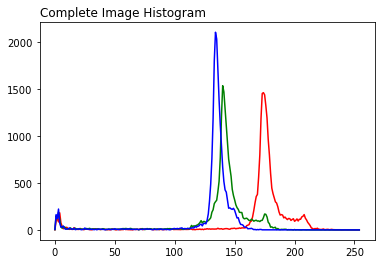

In [5]:
global G_rgb, pxl

mainWindow = tkinter.Tk()
mainWindow.title("Final Project by Bruno Ugolini: Image Segmentation GUI Inspired by DeepIGeoS (arXiv:1707.00652)")

# Initialize some parameters
white = (0, 0, 0) # color for new default image (misnomer)
fg_col = (255,   0,   0) # color of foreground scribble
bk_col = (  0,   0, 255) # color of background scribble
# fix the image dimensions to match the neural network input size
img_x_size, img_y_size = (224, 224)
rowspans = 20

width_of_window = 1260
height_of_window = 810

fg_counter, bk_counter = (0, 0) # initialize scribble counters
imageScaleFactor = 1
myFont = ("lucinda sans", "10")
myFontB = ("arial", "10", "bold")

img_dic = {
    "MinCut": "MinCut_target.png",
    "Net3": "Net3_target.png",
    "Net6": "Net6_target.png",
    "Prob": "Probability_target.png",
    "Rand": "random.png",
    "ForeGeod": "foregrnd_geodesic.png",
    "BackGeod": "backgrnd_geodesic.png"}

# load neural net models
print(f"Loading Net-3 ...")
net3 = tf.keras.models.load_model(NET_THREE)
print(f"Loading Net-6 ...")
net6 = tf.keras.models.load_model(NET_SIX)

# draw main window
screen_width = mainWindow.winfo_screenwidth()
screen_height = mainWindow.winfo_screenheight()

x_coordinate = (screen_width/2) - (width_of_window/2)
y_coordinate = (screen_height/2) - (height_of_window/2)

mainWindow.geometry("%dx%d+%d+%d" % (width_of_window, height_of_window, x_coordinate, y_coordinate))

# Get and draw the image
# choose random from data directory
pth = 'data/'
in_path = os.listdir(pth)
in_done = os.listdir('X/3/')
filenm = random.choice(list(set(in_path) - set(in_done)))
image = Image.open(pth+filenm)
image.save('test.png')
image = image.resize((img_x_size, img_y_size), Image.ANTIALIAS)
x_o, y_o = image.size # gather original size of image

# Create an image of random numbers
xrnd = np.random.rand(img_x_size,img_y_size) *255.
xrnd = Image.fromarray(xrnd.astype(np.uint8))
xrnd.save("random.png")

# create a dummy, blank image for initializing canvases
imageblank = Image.new("RGB", (x_o * imageScaleFactor, y_o * imageScaleFactor), white)
imageblank = ImageTk.PhotoImage(imageblank,master=mainWindow)
#================================
#
# Pen controls (penFrame)
#
#================================
penFrame = tkinter.Frame(mainWindow)
penFrame = tkinter.LabelFrame(mainWindow, text='Pen', font=myFont)
penFrame.grid(row=1, column=2, sticky='n')

# scale of the pen
penWidth = tkinter.Spinbox(penFrame, width=2, from_=1, to=10)
penWidth.grid(row=0, column=0)
penFrame.columnconfigure(0, weight=1)

#================================
#
# Probability and Graph Cut controls (probFrame)
#
#================================
probFrame = tkinter.Frame(mainWindow)
probFrame = tkinter.LabelFrame(mainWindow, text='Pr/Cut', font=myFont)
probFrame.grid(row=1, column=4, sticky='n')

button4 = tkinter.Button(probFrame, text='Prob Img', command=show_prob_img, font=myFont)
button4.grid(row=0, column=0)
probMn = tkinter.StringVar()
probMean = tkinter.Spinbox(probFrame, values=("Mean", "Harmonic"), textvariable=probMn, width=7)
probMn.set("Harmonic")
probMean.grid(row=1, column=0)
button5 = tkinter.Button(probFrame, text='Min-Cut', command=calc_region, font=myFont)
button5.grid(row=2, column=0)
probFrame.config(relief='sunken', borderwidth=3)
probFrame.grid(sticky='n') # nw, news, ... changes the extent of the frame

# Lambda for Cost function
lmbd = tkinter.StringVar(mainWindow)
lmbd.set("0.95")
lambdaCost = tkinter.Spinbox(probFrame, width=7, textvariable=lmbd,
                             from_=0, to=10, increment=0.05,
                             format="%.2f")
lambdaCost.grid(row=3, column=0)
#probFrame.columnconfigure(0, weight=1)

#================================
#
# Scribble controls (scribbleFrame
#
#================================

scribbleFrame = tkinter.Frame(mainWindow)
scribbleFrame = tkinter.LabelFrame(mainWindow, text='Scribbles', font=myFont)
scribbleFrame.grid(row=2, column=2, sticky='n')

button2 = tkinter.Button(scribbleFrame, text='Save FG', font=myFont, command=lambda : save_img('fg'))
# bandwidth for foreground
bw_fg = tkinter.StringVar(mainWindow)
bw_fg.set("0.1")
bwFrgrnd = tkinter.Spinbox(scribbleFrame, width=7, textvariable=bw_fg,
                             from_=0.1, to=1, increment=0.1,
                             format="%.1f")
button3 = tkinter.Button(scribbleFrame, text='Save BK', font=myFont, command=lambda : save_img('bk'))
bw_bk = tkinter.StringVar(mainWindow)
bw_bk.set("0.1")
bwBkgrnd = tkinter.Spinbox(scribbleFrame, width=7, textvariable=bw_bk,
                             from_=0.1, to=1, increment=0.1,
                             format="%.1f")
button2.grid(row=0, column=0)
bwFrgrnd.grid(row=1, column=0)
button3.grid(row=2, column=0)
bwBkgrnd.grid(row=3, column=0)
scribbleFrame.columnconfigure(0, weight=2)
#================================
#
# Image Frames (leftFrame) for image
# and colored scribbles
#
#================================
leftFrame = tkinter.Frame(mainWindow)
leftFrame.grid(row=1, column=1, rowspan=1)
labelorig = tkinter.Label(leftFrame, text='Original Image', font=myFontB)
labelorig.grid(row=1, column=0)
canvas = tkinter.Canvas(leftFrame, 
                        width=x_o*imageScaleFactor, 
                        height=y_o*imageScaleFactor, relief='raised', borderwidth=0)
canvas.grid(row=2, column=0)

image_orig = image.resize((x_o * imageScaleFactor, y_o * imageScaleFactor), Image.ANTIALIAS)
print(f"Image size scaled: {image_orig.size}")
image_mask = image_orig.convert(mode="L")
image = ImageTk.PhotoImage(image_orig,master=mainWindow)

plt.plot(image_orig.histogram(mask=image_mask)[0:255],color='red');
plt.plot(image_orig.histogram(mask=image_mask)[256:511],color='green');
plt.plot(image_orig.histogram(mask=image_mask)[512:767],color='blue');
plt.title("Complete Image Histogram",loc="left")
plt.savefig('hist_orig.png')

canvas.create_image(0,0, image=image, anchor='nw')

leftFrame.config(relief='sunken', borderwidth=10)
leftFrame.grid(sticky='ns')
#================================
#
# Initialize Graph
#
#================================
# get dictionary of pixel locations
pxl = x_y_for_p(image_orig.size)

# create all the edges (no attributes yet)
# on the image plane
print(f"Getting all image edges ...")
G = make_image_edges(image_orig, neighbors=8)

# remove from the Graph all the mask pixels
# and their associated edges by default
print(f"Removing mask nodes ...")
G_pic = remove_nodes_mask(G, image_mask, pxl)

# make the graph a strongly connected one
G_strong = convert_strongly(G_pic)

# get the variance of the pixel image
print(f"Getting pixel variance ...")
G_rgb, var = get_image_var(G_strong, image_orig, pxl, image_mask)
print(f"Variance: {var:0.4f}")
#================================
#
# Histogram Frame (histFrame) 
#
#================================
    
histFrame = tkinter.Frame(mainWindow)
histFrame.grid(row=1, column=3, sticky='n', rowspan=rowspans)
histFrame.config(relief='sunken', borderwidth=10)
labelhist = tkinter.Label(histFrame, text='Histograms', font=myFontB)
labelhist.grid(row=1, column=0)


# blank image for hist's
imageblankhst = Image.new("RGB", (360, 240), white)
imageblankhst = ImageTk.PhotoImage(imageblankhst,master=mainWindow)
# insert them
canvas_hist_fg = tkinter.Canvas(histFrame, width=360, height=240, relief='raised', borderwidth=0)
canvas_hist_fg.grid(row=3, column=0)
image_hist_fg = canvas_hist_fg.create_image(0,0, image=imageblankhst, anchor='nw')
canvas_hist_bk = tkinter.Canvas(histFrame, width=360, height=240, relief='raised', borderwidth=0)
canvas_hist_bk.grid(row=4, column=0)
image_hist_bk = canvas_hist_bk.create_image(0,0, image=imageblankhst, anchor='nw')

canvas_hist = tkinter.Canvas(histFrame, width=360, height=240, relief='raised', borderwidth=0)
canvas_hist.grid(row=2, column=0)
image_hst = Image.open("hist_orig.png")
image_hst = image_hst.resize((360,240), Image.ANTIALIAS)
image_hst = ImageTk.PhotoImage(image_hst,master=mainWindow)

canvas_hist.create_image(0,0, image=image_hst, anchor='nw')
#================================
# Probability Segmentation (probsegFrame)
#================================
probsegFrame = tkinter.Frame(mainWindow)
probsegFrame.grid(row=1, column=5, sticky='n', rowspan=rowspans)
probsegFrame.config(relief='sunken', borderwidth=10)
labelpb = tkinter.Label(probsegFrame, text='Probability Segmentation', font=myFontB)
labelpb.grid(row=1, column=0)
canvas_render = tkinter.Canvas(probsegFrame, 
                               width=x_o*imageScaleFactor, 
                               height=y_o*imageScaleFactor, relief='raised', borderwidth=0)
canvas_render.grid(row=2, column=0)
image_rend = canvas_render.create_image(0,0, image=imageblank, anchor='nw')
#================================
# GraphCut frame  (mincutFrame)
#================================
mincutFrame = tkinter.Frame(mainWindow)
mincutFrame.grid(row=2, column=5, sticky='n', rowspan=rowspans)
mincutFrame.config(relief='sunken', borderwidth=10)
labelminc = tkinter.Label(mincutFrame, text='Max-Flow / Min-Cut Segmentation', 
                          font=myFontB)
labelminc.grid(row=2, column=0)
canvas_region = tkinter.Canvas(mincutFrame, 
                               width=x_o*imageScaleFactor, 
                               height=y_o*imageScaleFactor, relief='raised', borderwidth=0)
canvas_region.grid(row=3, column=0)
image_region = canvas_region.create_image(0,0, image=imageblank, anchor='nw')
#================================
# Geodesic foreground frames (geoFrame)
#================================
geoFrame = tkinter.Frame(mainWindow)
geoFrame.grid(row=1, column=6, sticky='n', rowspan=rowspans)
geoFrame.config(relief='sunken', borderwidth=10)
labelgeo = tkinter.Label(geoFrame, text='Min Geodesic Distance to FG', font=myFontB)
labelgeo.grid(row=1, column=0)
canvas_geofg = tkinter.Canvas(geoFrame, 
                              width=x_o*imageScaleFactor, 
                              height=y_o*imageScaleFactor, relief='raised', borderwidth=0)
canvas_geofg.grid(row=2, column=0)
image_geofg = canvas_geofg.create_image(0,0, image=imageblank, anchor='nw')
#================================
# Geodesic background frames (geoFrame)
#================================
geobkFrame = tkinter.Frame(mainWindow)
geobkFrame.grid(row=2, column=6, sticky='n', rowspan=rowspans)
geobkFrame.config(relief='sunken', borderwidth=10)
labelgeobk = tkinter.Label(geobkFrame, text='Min Geodesic Distance to BK', font=myFontB)
labelgeobk.grid(row=2, column=0)
canvas_geobk = tkinter.Canvas(geobkFrame, 
                              width=x_o*imageScaleFactor, 
                              height=y_o*imageScaleFactor, relief='raised', borderwidth=0)
canvas_geobk.grid(row=3, column=0)
image_geobk = canvas_geobk.create_image(0,0, image=imageblank, anchor='nw')
#================================
# Geodesic Buttons (scribbleFrame)
#================================
geoFrame = tkinter.Frame(mainWindow)
geoFrame = tkinter.LabelFrame(mainWindow, text='Geod', font=myFont)
geoFrame.grid(row=2, column=4, sticky='n')

button6 = tkinter.Button(geoFrame, text='Geod FG', font=myFont, command=lambda : calc_geodesic('foregrnd'))
button6.grid(row=0, column=0)
button7 = tkinter.Button(geoFrame, text='Geod BK', font=myFont, command=lambda : calc_geodesic('backgrnd'))
button7.grid(row=1, column=0)
#================================
# Neural Net Buttons (netFrame)
#================================
netFrame = tkinter.Frame(mainWindow)
netFrame = tkinter.LabelFrame(mainWindow, text='NN', font=myFont)
netFrame.grid(row=3, column=4, sticky='n')

# Net-3 button
buttonn3 = tkinter.Button(netFrame, text='3-Net', font=myFont, command=lambda : calc_net3(3))
buttonn3.grid(row=0, column=0)
# Net-6 button
buttonn6 = tkinter.Button(netFrame, text='6-Net', font=myFont, command=lambda : calc_net6(6))
buttonn6.grid(row=1, column=0)

# Channel 4 selection box
ch4 = tkinter.StringVar()
meth_4 = tkinter.Spinbox(netFrame, values=("MinCut", "Prob", "Net3"), textvariable=ch4, width=7)
ch4.set("MinCut")
meth_4.grid(row=2, column=0)

# Channel 5 selection box
ch5 = tkinter.StringVar()
meth_5 = tkinter.Spinbox(netFrame, values=("Rand", "ForeGeod"), textvariable=ch5, width=7)
ch5.set("Rand")
meth_5.grid(row=3, column=0)

# Channel 6 selection box
ch6 = tkinter.StringVar()
meth_6 = tkinter.Spinbox(netFrame, values=("Rand", "BackGeod"), textvariable=ch6, width=7)
ch6.set("Rand")
meth_6.grid(row=4, column=0)

# generate the X,y dataset
# Net-3 button
buttonn3x = tkinter.Button(netFrame, text='3-X,y', font=myFont, command=lambda : copy_xy(3))
buttonn3x.grid(row=5, column=0)
# Net-6 button
buttonn6x = tkinter.Button(netFrame, text='6-X,y', font=myFont, command=lambda : copy_xy(6))
buttonn6x.grid(row=6, column=0)
# Channel 6 selection box
Y_sel = tkinter.StringVar()
meth_y = tkinter.Spinbox(netFrame, values=("Prob", "MinCut", "Net3", "Net6"), textvariable=Y_sel, width=7)
Y_sel.set("Prob")
meth_y.grid(row=7, column=0)
#================================
# 3-Channel Neural Net (net3Frame)
#================================
net3Frame = tkinter.Frame(mainWindow)
net3Frame.grid(row=3, column=5, sticky='n', rowspan=rowspans)
net3Frame.config(relief='sunken', borderwidth=10)
labelnet3 = tkinter.Label(net3Frame, text='Three-Channel Neural Network', font=myFontB)
labelnet3.grid(row=3, column=0)
canvas_net3 = tkinter.Canvas(net3Frame, 
                              width=x_o*imageScaleFactor, 
                              height=y_o*imageScaleFactor, relief='raised', borderwidth=0)
canvas_net3.grid(row=4, column=0)
image_net3 = canvas_net3.create_image(0,0, image=imageblank, anchor='nw')
#================================
# 6-Channel Neural Net (net6Frame)
#================================
net6Frame = tkinter.Frame(mainWindow)
net6Frame.grid(row=3, column=6, sticky='n', rowspan=rowspans)
net6Frame.config(relief='sunken', borderwidth=10)
labelnet6 = tkinter.Label(net6Frame, text='Six-Channel Neural Network', font=myFontB)
labelnet6.grid(row=3, column=0)
canvas_net6 = tkinter.Canvas(net6Frame, 
                              width=x_o*imageScaleFactor, 
                              height=y_o*imageScaleFactor, relief='raised', borderwidth=0)
canvas_net6.grid(row=4, column=0)
image_net6 = canvas_net6.create_image(0,0, image=imageblank, anchor='nw')
#================================
#
# Fill canvases
#
#================================

# PIL create an empty image and draw object to draw on
# memory only, not visible
# the foreground image ...

leftFrame2 = tkinter.Frame(mainWindow)
leftFrame2.grid(row=2, column=1, rowspan=1, sticky='ns')
labelL2 = tkinter.Label(leftFrame2, text='Foreground Scribbles', font=myFontB)
labelL2.grid(row=2, column=0)
imagefg = Image.new("RGB", (x_o * imageScaleFactor, y_o * imageScaleFactor), white)
drawfg = ImageDraw.Draw(imagefg)

# actually draw the blank foreground image
canvasfg = tkinter.Canvas(leftFrame2, 
                          width=x_o*imageScaleFactor, 
                          height=y_o*imageScaleFactor, relief='raised', borderwidth=0)
canvasfg.grid(row=3, column=0)
image_fg = canvasfg.create_image(0,0, image=imageblank, anchor='nw')

leftFrame2.config(relief='sunken', borderwidth=10)

leftFrame3 = tkinter.Frame(mainWindow)
leftFrame3.grid(row=3, column=1, rowspan=1, sticky='ns')
labelL3 = tkinter.Label(leftFrame3, text='Background Scribbles', font=myFontB)
labelL3.grid(row=2, column=0)
# the background image ...
imagebk = Image.new("RGB", (x_o * imageScaleFactor, y_o * imageScaleFactor), white)
drawbk = ImageDraw.Draw(imagebk)
# actually draw the blank background image
canvasbk = tkinter.Canvas(leftFrame3, 
                          width=x_o*imageScaleFactor, 
                          height=y_o*imageScaleFactor, relief='raised', borderwidth=0)
canvasbk.grid(row=3, column=0)
image_bk = canvasbk.create_image(0,0, image=imageblank, anchor='nw')
leftFrame3.config(relief='sunken', borderwidth=10)
#================================
#
# Define interactive buttons
#
#================================
    
canvas.bind("<Button-1>", get_x_and_y)
canvas.bind("<B1-Motion>", draw_squiggle)
   
canvas.bind("<Button-3>", get_x_and_y_bckgrnd)
canvas.bind("<B3-Motion>", draw_squiggle_bckgrnd)

mainWindow.mainloop()

In [13]:
in_path = os.listdir(pth)
in_done = os.listdir('X/3/')
random.choice(list(set(in_path) - set(in_done)))


'C118P79ThinF_IMG_20151002_110942_cell_20.png'